# Deal with the image+slit files

In [70]:
from pathlib import Path
import warnings
import yaml
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from mes_longslit import regrid_images

## Regrid the images to a common frame, centered on the source

In [50]:
datapath = Path.cwd().parent / "data"
inpath =  datapath / "wcs"
outpath = datapath / "regrid"
outpath.mkdir(exist_ok=True)

We can use the database file that I wrote, so we can separate the Ha from O III exposures.

In [55]:
db = yaml.safe_load(
    (datapath / "image-slit-database.yml").read_text()
)
db

[{'image_id': 'N10035', 'line_id': 'Ha'},
 {'image_id': 'N10042', 'line_id': 'Ha'},
 {'image_id': 'N10047o', 'problem': 'Missing'},
 {'image_id': 'N20001', 'problem': 'Unfocused'},
 {'image_id': 'N20008', 'line_id': 'O III'},
 {'image_id': 'N20011', 'line_id': 'Ha'},
 {'image_id': 'spm0020o', 'line_id': 'Ha'},
 {'image_id': 'spm0025o', 'line_id': 'O III'},
 {'image_id': 'spm0047o', 'line_id': 'Ha'},
 {'image_id': 'spm0052o', 'line_id': 'O III'},
 {'image_id': 'spm0053o', 'line_id': 'Ha'},
 {'image_id': 'spm0058o', 'line_id': 'O III'},
 {'image_id': 'spm0109o', 'line_id': 'O III'},
 {'image_id': 'spm0210o', 'line_id': 'Ha'},
 {'image_id': 'spm0214o', 'line_id': 'Ha'},
 {'image_id': 'spm0431o', 'line_id': 'Ha'},
 {'image_id': 'spm0439o', 'line_id': 'Ha'},
 {'image_id': 'spm0600o', 'line_id': 'Ha'}]

In [58]:
ha_list = [_["image_id"] for _ in db if _.get("line_id") == "Ha"]
o3_list = [_["image_id"] for _ in db if _.get("line_id") == "O III"]

These are the coordinates of `PN Ou 5` [according to SIMBAD](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=PN+Ou+5)

In [42]:
c0 = SkyCoord("21 14 20.03 +43 41 36.0", unit=(u.hourangle, u.deg))
c0

<SkyCoord (ICRS): (ra, dec) in deg
    (318.58345833, 43.69333333)>

We only need a small image around the center, since it is a small nebula.  We take 256 pixel square with 0.2 arcsec per pixel, so 51.2 arcsec along each side. The smallest pixels in the original data are 0.35 arcsec, so we are oversampling enough to hopefully avoid any aliasing issues.

In [59]:
ha_dict = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for _id in ha_list:
        infile = inpath / f"cr{_id}_b-wcs.fits"
        hdulist = fits.open(infile)
        ha_dict[_id] = regrid_images(
            hdulist, 
            center=c0, 
            pixscale=0.2 * u.arcsec,
            shape=(256, 256),
        )    

In [60]:
ha_dict

{'N10035': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f752eddf0>],
 'N10042': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f3070a1c0>],
 'N20011': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f3070a160>],
 'spm0020o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f74961d30>],
 'spm0047o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f306f83a0>],
 'spm0053o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f752edf10>],
 'spm0210o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f30706070>],
 'spm0214o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f7508d130>],
 'spm0431o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f7496bb80>],
 'spm0439o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f75d4ea30>],
 'spm0600o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f4245e8e0>]}

In [61]:
o3_dict = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for _id in o3_list:
        infile = inpath / f"cr{_id}_b-wcs.fits"
        hdulist = fits.open(infile)
        o3_dict[_id] = regrid_images(
            hdulist, 
            center=c0, 
            pixscale=0.2 * u.arcsec,
            shape=(256, 256),
        )  
o3_dict

{'N20008': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f74961e50>],
 'spm0025o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7fb12a4910>],
 'spm0052o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f7496b7c0>],
 'spm0058o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7fb148ad60>],
 'spm0109o': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f7f74d31b50>]}

Look at one of the results to make sure things are OK

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

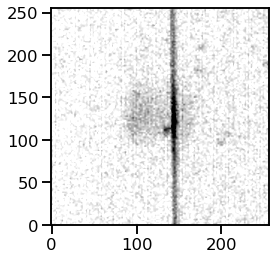

In [81]:
hdu = ha_dict["N20011"][0]
w = WCS(hdu.header)
fig, ax = plt.subplots(
    figsize=(4, 4),
#    subplot_kw=dict(projection=w)
)
ax.imshow(hdu.data, cmap="gray_r", origin="lower", vmin=-5, vmax=12)
# ax.set(
#     xlabel="RA",
#     ylabel="DEC",
# )

## Normalize the images

Define regions for normalizing the image.  Each window is 50x50 pixels
* `peak_window` is the central portion
* `bg_windows` is a list of the 4 corners

In [68]:
peak_window = slice(100, 150), slice(100, 150)
bg_windows = [
    (slice(None, 50), slice(None, 50)),
    (slice(-50, None), slice(None, 50)),
    (slice(None, 50), slice(-50, None)),
    (slice(-50, None), slice(-50, None)),    
]

def normalize(im):
    """Subtract background and divide by peak"""
    bg = np.mean(
        [np.median(im[window]) for window in bg_windows]
    )
    im_new = im - bg
    peak = np.median(im_new[peak_window])
    im_new /= peak
    return im_new

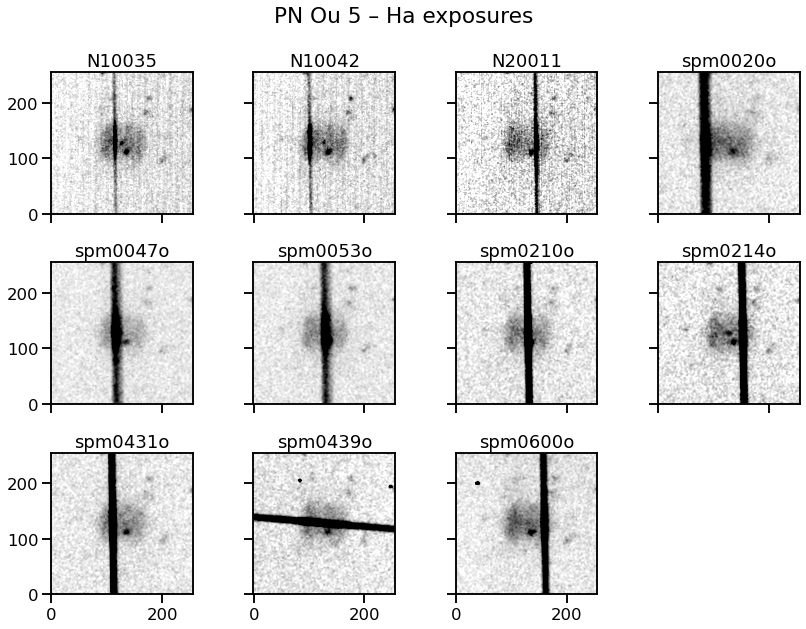

In [86]:
fig, axes = plt.subplots(
    3, 4, sharex=True, sharey=True,
    figsize=(12, 9),
)
for ax, (name, hdulist) in zip(axes.flat, ha_dict.items()):
    hdu = hdulist[0]
    ax.imshow(normalize(hdu.data), cmap="gray_r", origin="lower", vmin=-0.2, vmax=2.0)
    ax.set_title(name)
axes[-1, -1].remove()
fig.suptitle("PN Ou 5 – Ha exposures")
fig.tight_layout()
fig.savefig("ha-image-slit-mosaic.pdf")

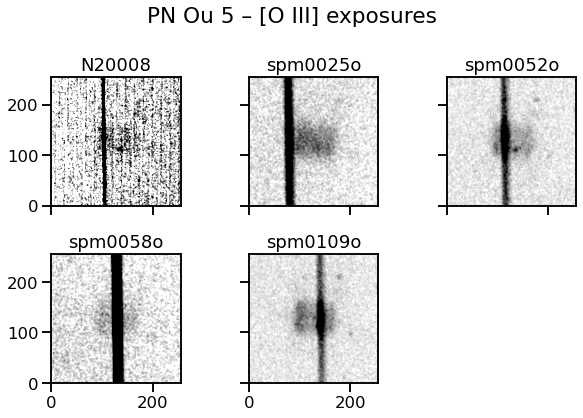

In [88]:
fig, axes = plt.subplots(
    2, 3, sharex=True, sharey=True,
    figsize=(9, 6),
)
for ax, (name, hdulist) in zip(axes.flat, o3_dict.items()):
    hdu = hdulist[0]
    ax.imshow(normalize(hdu.data), cmap="gray_r", origin="lower", vmin=-0.2, vmax=2.0)
    ax.set_title(name)
axes[-1, -1].remove()
fig.suptitle("PN Ou 5 – [O III] exposures")
fig.tight_layout()
fig.savefig("o3-image-slit-mosaic.pdf")

In [67]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 318.58345833333  43.693333333333  
CRPIX : 128.5  128.5  
CD1_1 CD1_2  : -4.05344062019e-07  -9.74613192003e-05  
CD2_1 CD2_2  : 9.74613192003e-05  -4.05344062019e-07  
NAXIS : 256  256

In [31]:
tform = ax.get_transform("icrs")

In [33]:
tform.get_matrix()

array([[ 1.06171875,  0.        , 97.73085938],
       [ 0.        ,  1.06171875, 90.53085938],
       [ 0.        ,  0.        ,  1.        ]])